# Introduzione a PyTorch

PyTorch fornisce diversi moduli, di cui ``torch.nn`` è quello base per  la creazione dei modelli neurali, mentre i dati sono gestiti tramite ``torch.utils.data.DataSet`` che si occupa di caricare i dati dalle sorgenti e creare i tensori e ``torch.utils.data.DataLoader`` che si occupa di creare i batch e caricarli sul device selezionato per l'addestramento.
Esitono poi le librerie ``torchvision``, ``torchtext`` e ``torchaudio`` che forniscono data set specifici e funzioni di gestione per i tre domini di riferimento.

In [1]:
# Importiamo tutte le librerire necessarie
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import datasets
from torchvision.transforms import ToTensor
import os.path
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm import tqdm

In [2]:
# Connettiamoci a Google Drive per salvare i dati
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


All'interno della cartella ``/content/gdrive`` che è un mountpoint convenzionale, troviamo ``MyDrive`` e ``Shareddrives``. In ``Mydrive`` ritroveremo tutta la struttura di cartelle presenti nel nostro Google Drive, per cui possiamo certamente stabilire una root dei nostri dati e dei nostri notebook, che ciascuno farà puntare ad una cartella di propria scelta.

**Nota Bene:** i percorsi sono in stile Linux.


In [3]:
# root dei percorsi
root = "/content/gdrive/MyDrive/ColabNotebooks/torch"
os.makedirs(root, exist_ok='True')
# percorso dei dati
data_path = os.path.join(root,'data')

# lo creiamo la prima volta
if not os.path.exists(data_path):
    os.mkdir(data_path)

# Analogamente per il percorso dei modelli
model_path = os.path.join(root,'models')

if not os.path.exists(model_path):
    os.mkdir(model_path)


Useremo il database ``FashionMNIST``per il nostro esempio: si tratta di 70000 immagini di dimensione 28x28, a livelli di grigio, che ritraggono capi di abbigliamento e sono associate a delle etichette testuali ch riportano il tipo di capo.

Abbiamo a che fare quindi con un problema di classificazione multiclasse di immagini che affronteremo con una rete neurale convoluizonale.

Il data set è suddiviso in un training set da 60000 immagini e un test set da 10000 immagini. Eseguiremo il download direttamente tramite ``torch`` che genererà un ``DataSet``.

In [4]:
# flag per forzare il download del data set solo la prima volta
download = not os.path.exists(os.path.join(data_path,'FashionMNIST'))

# Download del training set da un open data set.
training = datasets.FashionMNIST(
    root=data_path,
    train=True,         # esegue il download dalla cartella/archivio dei dati di train del data set originale
    download=download,
    transform=ToTensor(),
)

# Download del training set da un open test set.
test_data = datasets.FashionMNIST(
    root=data_path,
    train=False,
    download=download,
    transform=ToTensor(),
)

# eseguiamo lo split 90% - 10% dei dati di train per creare il validation set
training_size = int(0.9 * len(training))
val_size = int(0.1 * len(training))

training_data, val_data = random_split(training, [training_size, val_size])

print(f"Campioni nel training set: {len(training_data)}\
        \nCampioni nel validation set: {len(val_data)}\
        \nCampioni nel test set: {len(test_data)}")

Campioni nel training set: 54000        
Campioni nel validation set: 6000        
Campioni nel test set: 10000


### Tensori

Nel codice precedente abbiamo visto che la trasformazione usata nella creazione dei data set è quella tipica, ovvero la chiamata di ``torchvision.ToTensor()`` che converte un'immagine di dimensioni HxWxC in un tensore di dimensioni CxHxW. Le trasformazioni possono essere anche definite dall'utente attraverso funzioni lambda.

I tensori in Pytorch sono implementati in maniera molto simile agli array in ``numpy``: essi hanno diversi tipi dei dati, infatti la classe base ``torch.Tensor`` è il default che ha un ``dtype=torc.float32`` ed è un alias per ``torch.FloatTensor``.
Pytorch usa i tensori per implementare tutta l'algebra lineare, le operazioni di campionamento, e quelle che guidano la propagazione dei gradienti durante l'addestramento.

I tensori possono essere creati da specifiche operazioni che danno come risultato un tensore, come ``torch.randint()`` che vedremo tra poco e che genera un tensore di numeri interi casuali di data dimensione, oppure esplicitamente con ``torch.tensor()`` che crea un tensore da una struttura di tipo array.

### Dataset
Un ``Dataset`` è in genere implementato come una ``map`` Python, quindi con accesso a indice, ma può essere anche creato come sottoclasse di ``IterableDataset`` come un iteratore.

Diamo un'occhiata al nostro data set, ricordandoci che è implementato con accesso ad indice.

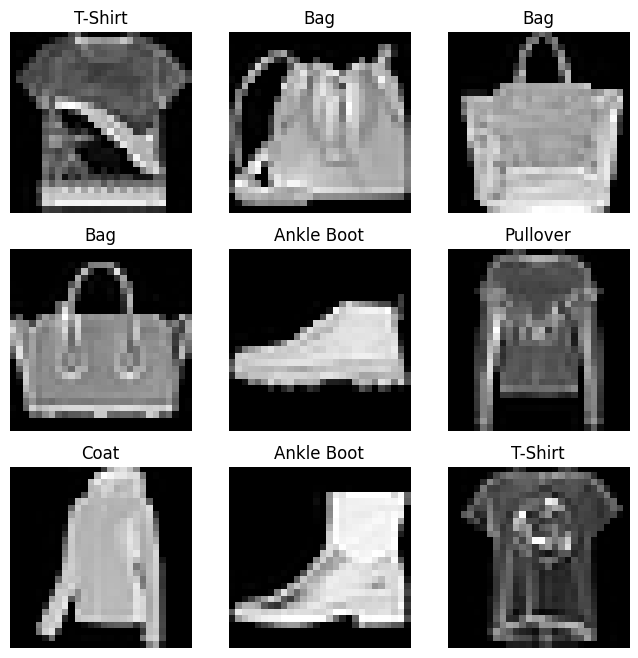

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # Genero un tensore casuale composto da un solo elemento nel range della lunghezza del data set
    # e lo converto in numero usando il metodo Tensor.item()
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [7]:
# Al fine di localizzare la zona di codice su cui intervenire
# definiamo un dict che contenga tutti gli iperparametri del modello
# potremo variarli quando vorremo agendo solo qui

hyperparameters = {
    "learning_rate": 1e-3,
    "batch_size": 64,
    "epochs": 20,
    "patience": 5,
    "min_delta": 0.01,
    "momentum": 0.9,
    "nesterov": True
}

In [8]:
# Spostiamo i dati sulla GPU
training_data.dataset.data.to(device)
val_data.dataset.data.to(device)
test_data.data.to(device)

# Creiamo i data loaders che saranno gli iteraboili che generano i batch di
# addestramento e/o test
train_dataloader = DataLoader(training_data,
                            batch_size=hyperparameters['batch_size'], # Imposta la dimensione del batch
                            shuffle=True,                             # Shuffling dei batch tra un'epoca e l'altra
                            num_workers=2,                            # Numero dei sottoprocessi di caricamento dei dati
                            prefetch_factor=12,                       # Campioni precaricati da ogni sottoprocesso
                            pin_memory=True)                          # Usa la memoria non paginata per muovere i tensori
                                                                      # da CPU a GPU
val_dataloader = DataLoader(val_data,
                            batch_size=hyperparameters['batch_size'],
                            shuffle=True,
                            num_workers=2,
                            prefetch_factor=12,
                            pin_memory=True)

test_dataloader = DataLoader(test_data,
                            batch_size=hyperparameters['batch_size'],
                            shuffle=True,
                            num_workers=2,
                            prefetch_factor=12,
                            pin_memory=True)

# semplice investigazione della shape dei tensori: usiamo il primo
# batch del test dataloader come esempio
for X, y in test_dataloader:
    print(f"Shape di X [N, C, H, W]: {X.shape}")
    print(f"Shape di y: {y.shape} {y.dtype}")
    break

Shape di X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape di y: torch.Size([64]) torch.int64


In [9]:
#  Creiamo il modello
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.deep_conv_stack = nn.Sequential(
            nn.Conv2d(1, 64, 3),        # Shape: (N, 1, 28, 28)   --> (N, 64, 26, 26) a causa del kernel 3x3
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),      # Shape: (N, 64, 26, 26)  --> (N, 128, 24, 24)
            nn.ReLU(),
            nn.Conv2d(128, 256, 3),     # Shape: (N, 128, 24, 24) --> (N, 256, 22, 22)
            nn.ReLU(),
            nn.Conv2d(256, 64, 3),      # Shape: (N, 256, 22, 22) --> (N, 64, 20, 20)
            nn.ReLU(),
            nn.AvgPool2d(2),            # Shape: (N, 256, 20, 20) --> (N, 64, 10, 10) a causa della divisione per due
            nn.Conv2d(64, 32, 3),       # Shape: (N, 64, 10, 10)  --> (N, 32, 8, 8)
            nn.ReLU(),
            nn.AvgPool2d(2),            # Shape: (N, 32, 8, 8)    --> (N, 32, 4, 4)
            nn.Flatten(),               # Shape: (N, 32, 4, 4)    --> (N, 512) il flatten moltiplica tutte le dimensioni tra loro
            nn.Linear(512, 10)          # Shape: (N, 512)         --> (N, 10) strato denso di calcolo dei logits
        )

    def forward(self, x):
        # Calcolo della rete in avanti
        logits = self.deep_conv_stack(x)                # parte profonda della rete che estrae i logits
        pred_probab = nn.LogSoftmax(dim=1)(logits)      # uscita esplicita con log-softmax per la predizione delle etichette
        return pred_probab

# Il metodo to() sposta il modello sul device selezionato
model = NeuralNetwork().to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

NeuralNetwork(
  (deep_conv_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=512, out_features=10, bias=True)
  )
)
Numbero totale dei parametri: 540778


In [10]:
loss_fn = nn.NLLLoss()               # Negative log-likelihood

optimizer = torch.optim.SGD(
                            model.parameters(),
                            lr=hyperparameters['learning_rate'],
                            momentum=hyperparameters['momentum'],
                            nesterov=hyperparameters['nesterov']
                            )

L'addestramento e il test si effettuano come dei loop sui diversi batch, in cui esplicitamente si comanda il passo di backpropagation e/o di predizione e si stabilisce quando non devono essere calcolati i gradienti.

Pytorch non implementa l'early stopping come procedura embedded nella libreria e quindi è sempre necessario implementarlo con codice proprio. Definiremo un'apposita classe ``EarlyStopping`` a questo fine:

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza


Definiremo adesso una API di addestramento e test del modello in cui due funzioni implementano, rispettivamente, un'epoca di train e test. Successivamente, definiremo un wrapper che implementa l'addestramento e test lungo un ciclo di epoche in cui si inserirà l'early stopping.

In [31]:
def train_loop(model, dataloader, loss_fn, optimizer, device, pbar):

    num_batches = len(dataloader)
    epoch_loss = 0.0

    # Impostiamo la modalità di training del modello: è una best practice che serve per il
    # dropout e/o batch normalization
    model.train()
    for _, (X, y) in zip(pbar,dataloader):      # questa iterazione fatta così garantisce l'avanzamento della progress
                                                # bar mentre i batch vengono prelevati dal dataloader

        # Spostiamo esplicitamente i tensori sul device di computazione
        X, y = X.to(device), y.to(device)

        # Passo esplicito di addestramento
        optimizer.zero_grad()                   # azzeriamo i gradienti dell'iterata precedente

        # Calcoliamo la loss ed effettuiamo la predizione del minibatch
        logits = model(X)
        batch_loss = loss_fn(logits, y)

        epoch_loss += batch_loss.item()

        batch_loss.backward()             # step di backpropagation

        optimizer.step()                  # passo di ottimizzazione e aggiornamento dei parametri


    # Ritorniamo la loss media dell'epoca
    return epoch_loss/num_batches

def eval_loop(model, dataloader, loss_fn, device):

    # Impostiamo la modalità di valutazione del modello: è una best practice che serve per il
    # dropout e/o batch normalization
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy = 0.0, 0

    y_true = []
    y_pred = []

    # context manager che disabilita esplicitamente il calcolo dei gradienti in fase di test
    with torch.no_grad():
        for X, y in dataloader:

            # Spostiamo esplicitamente i tensori sul device di computazione
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # L'accuracy sul batch si calcola creando il tensore di dimensione pari al batch
            # per cui i massimi argomenti di ogni predizione sono uguali alla classe predetta
            # per il singolo campione, poi convertendo questo tensore di booleani in un vettore
            # binario difloat, sommando i valori 1 ed estraendo lo scalare contenuto nel tensore risultato
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.argmax(1).cpu().numpy())

    test_loss /= num_batches
    accuracy /= size            # Per quanto detto prima, l'accuracy media va calcolata sulla dimensione del data set

    # Calculate precision, recall, and F1-score alla fine per epoca
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return test_loss, accuracy, precision, recall, f1

# Ciclo di addestramento completo con test, early stopping e scheduler del learning rate
def train_test(model,
               epochs,
               optimizer,
               device,
               train_dataloader,
               test_dataloader,
               loss_fn,
               early_stopping=None,       # posso addstrare senza early stopping
               val_dataloader=None,       # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss, validation_loss, test_loss = [], [], []
    accuracy = []
    precision, recall, f1 = [], [], []

    num_batches = len(train_dataloader)

    # Ciclo di addestramento con early stopping
    for epoch in range(1,epochs+1):

        # Progress bar
        pbar = trange(num_batches)
        pbar.set_description(desc='Epoch {:4d}'.format(epoch))

        epoch_train_loss = train_loop(model, train_dataloader, loss_fn, optimizer, device, pbar)
        train_loss.append(epoch_train_loss)

        # validation se è presente val_dataloader
        if val_dataloader != None:
                epoch_validate_loss, _, _, _, _ = eval_loop(model, val_dataloader, loss_fn, device)
                validation_loss.append(epoch_validate_loss)

        # test
        epoch_test_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_f1 = eval_loop(model, test_dataloader, loss_fn, device)

        test_loss.append(epoch_test_loss)
        accuracy.append(epoch_accuracy)
        precision.append(epoch_precision)
        recall.append(epoch_recall)
        f1.append(epoch_f1)

        val_str = f'Validation loss: {epoch_validate_loss:6.4f}\n' if val_dataloader != None else ' '

        print(f"Train loss: {epoch_train_loss:6.4f}\n{val_str}Test loss: {epoch_test_loss:6.4f} Accuracy: {epoch_accuracy:6.2f}\nPrecision: {epoch_precision:6.2f} Recall: {epoch_recall:6.2f} f1: {epoch_f1:6.2f}")

        # early stopping
        if early_stopping != None:
            early_stopping(epoch_validate_loss)
            if early_stopping.early_stop:
                break

        # scheduler dell'iperparametro
        if scheduler != None:
            scheduler.step()

    return train_loss, validation_loss, test_loss, accuracy, precision, recall, f1


In [13]:
# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])

# Routine di addestramento
train_loss, validation_loss, test_loss, accuracy, precision, recall, f1 = train_test(model,
                                                              hyperparameters['epochs'],
                                                              optimizer,
                                                              device,
                                                              train_dataloader,
                                                              test_dataloader,
                                                              loss_fn,
                                                              early_stopping,
                                                              val_dataloader)

Epoch    1: 100%|██████████| 844/844 [00:16<00:00, 52.42it/s]


Train loss: 1.5516
Validation loss: 0.7259
Test loss: 0.7499 Accuracy:   0.72
Precision:   0.71 Recall:   0.72 f1:   0.70


Epoch    2: 100%|██████████| 844/844 [00:15<00:00, 52.77it/s]


Train loss: 0.6778
Validation loss: 0.6161
Test loss: 0.6413 Accuracy:   0.77
Precision:   0.76 Recall:   0.77 f1:   0.75


Epoch    3: 100%|██████████| 844/844 [00:15<00:00, 54.20it/s]


Train loss: 0.5834
Validation loss: 0.5663
Test loss: 0.5939 Accuracy:   0.78
Precision:   0.79 Recall:   0.78 f1:   0.78


Epoch    4: 100%|██████████| 844/844 [00:16<00:00, 52.52it/s]


Train loss: 0.5298
Validation loss: 0.5187
Test loss: 0.5434 Accuracy:   0.79
Precision:   0.80 Recall:   0.79 f1:   0.79


Epoch    5: 100%|██████████| 844/844 [00:15<00:00, 53.53it/s]


Train loss: 0.4976
Validation loss: 0.4818
Test loss: 0.5096 Accuracy:   0.82
Precision:   0.82 Recall:   0.82 f1:   0.81


Epoch    6: 100%|██████████| 844/844 [00:15<00:00, 53.58it/s]


Train loss: 0.4714
Validation loss: 0.4735
Test loss: 0.4940 Accuracy:   0.81
Precision:   0.83 Recall:   0.81 f1:   0.82


Epoch    7: 100%|██████████| 844/844 [00:15<00:00, 54.79it/s]


Train loss: 0.4512
Validation loss: 0.4436
Test loss: 0.4609 Accuracy:   0.83
Precision:   0.83 Recall:   0.83 f1:   0.83


Epoch    8: 100%|██████████| 844/844 [00:15<00:00, 53.91it/s]


Train loss: 0.4369
Validation loss: 0.4375
Test loss: 0.4573 Accuracy:   0.83
Precision:   0.83 Recall:   0.83 f1:   0.83


Epoch    9: 100%|██████████| 844/844 [00:15<00:00, 55.07it/s]


Train loss: 0.4226
Validation loss: 0.4424
Test loss: 0.4641 Accuracy:   0.83
Precision:   0.84 Recall:   0.83 f1:   0.83


Epoch   10: 100%|██████████| 844/844 [00:15<00:00, 55.32it/s]


Train loss: 0.4119
Validation loss: 0.4265
Test loss: 0.4424 Accuracy:   0.84
Precision:   0.85 Recall:   0.84 f1:   0.84


Epoch   11: 100%|██████████| 844/844 [00:15<00:00, 54.33it/s]


Train loss: 0.4012
Validation loss: 0.3957
Test loss: 0.4145 Accuracy:   0.85
Precision:   0.85 Recall:   0.85 f1:   0.85


Epoch   12: 100%|██████████| 844/844 [00:15<00:00, 54.39it/s]


Train loss: 0.3930
Validation loss: 0.4128
Test loss: 0.4295 Accuracy:   0.84
Precision:   0.85 Recall:   0.84 f1:   0.84


Epoch   13: 100%|██████████| 844/844 [00:15<00:00, 53.41it/s]


Train loss: 0.3868
Validation loss: 0.3863
Test loss: 0.4021 Accuracy:   0.86
Precision:   0.86 Recall:   0.86 f1:   0.85


Epoch   14: 100%|██████████| 844/844 [00:15<00:00, 54.23it/s]


Train loss: 0.3790
Validation loss: 0.3861
Test loss: 0.4035 Accuracy:   0.86
Precision:   0.86 Recall:   0.86 f1:   0.86


Epoch   15: 100%|██████████| 844/844 [00:15<00:00, 54.94it/s]


Train loss: 0.3740
Validation loss: 0.3848
Test loss: 0.4010 Accuracy:   0.85
Precision:   0.86 Recall:   0.85 f1:   0.85


Epoch   16: 100%|██████████| 844/844 [00:15<00:00, 54.86it/s]


Train loss: 0.3684
Validation loss: 0.3834
Test loss: 0.3962 Accuracy:   0.86
Precision:   0.86 Recall:   0.86 f1:   0.86


Epoch   17: 100%|██████████| 844/844 [00:15<00:00, 54.13it/s]


Train loss: 0.3623
Validation loss: 0.3744
Test loss: 0.3901 Accuracy:   0.86
Precision:   0.86 Recall:   0.86 f1:   0.85


Epoch   18: 100%|██████████| 844/844 [00:15<00:00, 54.95it/s]


Train loss: 0.3573
Validation loss: 0.3718
Test loss: 0.3849 Accuracy:   0.86
Precision:   0.86 Recall:   0.86 f1:   0.86


Epoch   19: 100%|██████████| 844/844 [00:15<00:00, 55.00it/s]


Train loss: 0.3523
Validation loss: 0.3627
Test loss: 0.3736 Accuracy:   0.87
Precision:   0.87 Recall:   0.87 f1:   0.86


Epoch   20: 100%|██████████| 844/844 [00:15<00:00, 53.82it/s]


Train loss: 0.3470
Validation loss: 0.3519
Test loss: 0.3637 Accuracy:   0.87
Precision:   0.87 Recall:   0.87 f1:   0.87


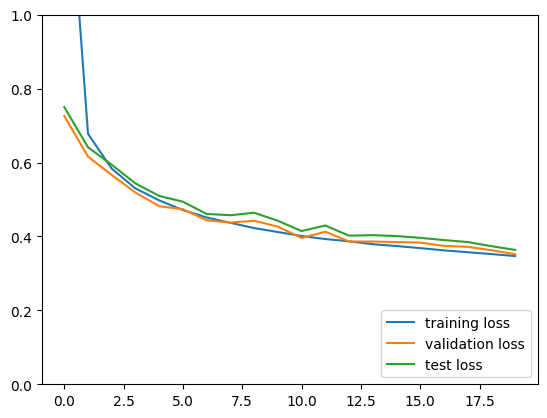

In [14]:
plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()

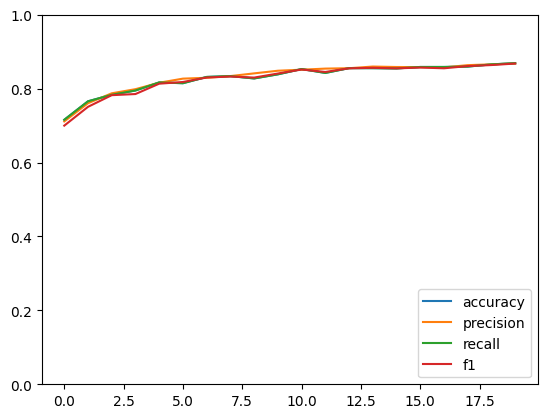

In [15]:
plt.plot(accuracy, label='accuracy')
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.plot(f1, label='f1')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()

## Salvataggio e caricamento del modello

Come già sappiamo, quando l'addestramento si interrompe a causa di un early stoppping ovvero perché è necessario frazionarlo per gestire le risorse limitate della GPU, ma anche semplicemente alla sua fine naturale il modello viene salvato per poterlo successivamente ricaricare a fini di fine tuning o di predizione. Si usa chiamare questa azione _model checkpoint_.

Anche questa operazione andrà codificata creando delle semplici API basate sulle primitive di ``Torch`` denominate ``torch.save()`` e ``torch.load()`` le quali salvano un qualunque ``dict`` in forma serializzata utilizzando il modulo nativo ``Python`` denominato ``pickle``.

Creeremo due semplici wrapper per le operazioni di salvataggio e caricamento del model checkpoint.

In [16]:
def save_model(net, optimizer, current_epoch, train_loss, val_loss, test_loss, accuracy, precision, recall, f1, path):

    # Abbiamo deciso per queste informazioni, ma possiamo caricare qualunque cosa
    torch.save({
            'epoch': current_epoch,
            'model_state_dict': net.state_dict(),               # configurazione di tutti i layer *addestrabili* del modello
            'optimizer_state_dict': optimizer.state_dict(),     # configurazione e operparametri dell'ottimizzatore
            'training_loss': train_loss,
            'validation_loss': val_loss,
            'test_loss': test_loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
            }, path)


def load_model(path, ModelClass=nn.Module, OptimizerClass=torch.optim.Optimizer, device = None):

    # Ricarichiamo il dizionario e restituiamo la tupla delle informazioni
    # La rete e l'ottimizzatore devono essere inizializzate prima di caricare
    # lo stato salvato

    # Inizializziamo il modello con la classe di rete neurale richiesta
    model = ModelClass()

    # Se il device è specificato e non è la CPU, allora muoviamo il modello sul device
    if device != None and device != 'cpu':
        model.to(device)

    # Analogo discorso per l'ottimizzatore
    optimizer = OptimizerClass(model.parameters(), lr=0.001, momentum=0.9)

    # carichiamo il model checkpoint
    checkpoint = torch.load(path)

    # inizializziamo lo stato del modello e dell'ottimizzatore
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # restituiamo tutte le informazioni in una tupla
    return (model,
            optimizer,
            checkpoint['epoch'],
            checkpoint['training_loss'],
            checkpoint['validation_loss'],
            checkpoint['test_loss'],
            checkpoint['accuracy'],
            checkpoint['precision'],
            checkpoint['recall'],
            checkpoint['f1']
            )


In [18]:
# utilizziamo le API per salvare e ricaricare il modello
save_model(model,
           optimizer,
           len(train_loss),
           train_loss,
           validation_loss,
           test_loss,
           accuracy,
           precision, recall, f1,
           os.path.join(model_path,'first_nn_torch.pth'))

(mod, opt, ep, tr_loss, val_loss, ts_loss, acc, prec, rec, ff1) = load_model(os.path.join(model_path,'first_nn_torch.pth'),
                                                              NeuralNetwork,
                                                              torch.optim.SGD,
                                                              device=device)

In [35]:
(mod, opt, ep, tr_loss, val_loss, ts_loss, acc, prec, rec, ff1) = load_model(os.path.join(model_path,'first_nn_torch.pth'),
                                                              NeuralNetwork,
                                                              torch.optim.SGD,
                                                              device=device)

In [36]:
# Vogliamo riaddestrare il modello dopo l'early stopping, per cui
# inseriamo uno scheduler che faccia decrescere il learning rate ad ogni epoca
# come ulteriore regolarizzazione
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

# Usiamo lo scheduler al posto dell'ottimizzatore nell'addestramento
train_loss, validation_loss, test_loss, accuracy, precision, recall, f1 = train_test(mod, 5, opt, device, train_dataloader, test_dataloader,
                                                              loss_fn, scheduler=scheduler, val_dataloader=val_dataloader)

Epoch    1: 100%|██████████| 844/844 [00:15<00:00, 54.27it/s]


Train loss: 0.3428
Validation loss: 0.3756
Test loss: 0.3875 Accuracy:   0.86
Precision:   0.86 Recall:   0.86 f1:   0.85


Epoch    2: 100%|██████████| 844/844 [00:16<00:00, 52.18it/s]


Train loss: 0.3353
Validation loss: 0.3578
Test loss: 0.3688 Accuracy:   0.87
Precision:   0.87 Recall:   0.87 f1:   0.87


Epoch    3: 100%|██████████| 844/844 [00:15<00:00, 54.74it/s]


Train loss: 0.3304
Validation loss: 0.3505
Test loss: 0.3639 Accuracy:   0.87
Precision:   0.87 Recall:   0.87 f1:   0.86


Epoch    4: 100%|██████████| 844/844 [00:15<00:00, 55.51it/s]


Train loss: 0.3257
Validation loss: 0.3323
Test loss: 0.3461 Accuracy:   0.88
Precision:   0.88 Recall:   0.88 f1:   0.88


Epoch    5: 100%|██████████| 844/844 [00:15<00:00, 54.81it/s]


Train loss: 0.3214
Validation loss: 0.3451
Test loss: 0.3567 Accuracy:   0.87
Precision:   0.87 Recall:   0.87 f1:   0.87


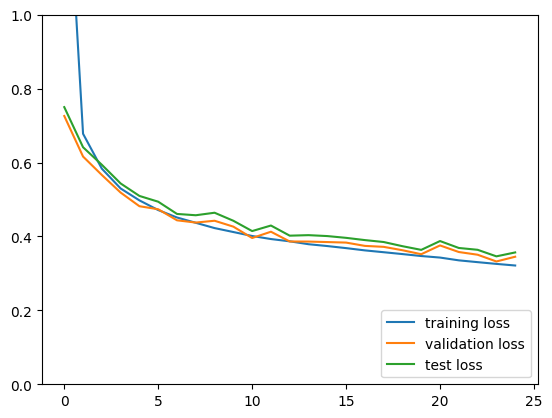

In [37]:
# concateniamo le liste delle loss relative ai due addestramenti e facciamo il plot
tr_loss.extend(train_loss)
val_loss.extend(validation_loss)
ts_loss.extend(test_loss)

plt.plot(tr_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.plot(ts_loss, label='test loss')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()

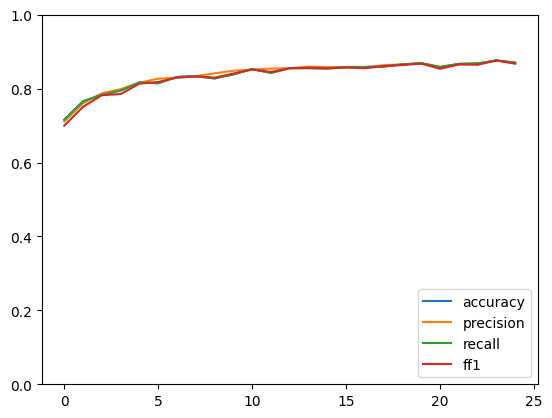

In [38]:
# concateniamo le liste delle metriche relative ai due addestramenti e facciamo il plot
acc.extend(accuracy)
prec.extend(precision)
rec.extend(recall)
ff1.extend(f1)

plt.plot(acc, label='accuracy')
plt.plot(prec, label='precision')
plt.plot(rec, label='recall')
plt.plot(ff1, label='ff1')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()